# 5G Localization

## Read matlab files to dataframes

In [1]:
import concurrent.futures
import os

import numpy as np
import pandas as pd
import tqdm

from scripts.data_loader import load_matlab_file_as_df
from scripts.plotting import make_boxplot
from scripts.utils import compute_metrics, RF_PARAM
from scripts.weighted_coverage import run_weighted_coverage

# source file
BASE_DIR = "data/"
FULL_DATA_SET = "Campaign_data_NBIoT_1_2_3_4_5_6_interpolated_smoothed.mat"
filename = os.path.join(BASE_DIR, FULL_DATA_SET)

# load the dataset as pandas dataframe
df = load_matlab_file_as_df(
    filename=filename,
    dataset='dataSet_smooth',  # dataSet, dataSet_interp or dataSet_smooth
    usecols=['lat', 'lng', 'measurements_matrix']
)

np.random.seed(42)  # For reproducibility


## Running the weighted coverage strategy

In [2]:
n_runs = 40
k_max = 5
# Initialize a list to store the average errors
print(f'Running wknn with max-k = {k_max}, over {n_runs} runs')
errors = []
tp_est_locations = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(run_weighted_coverage, df, RF_PARAM.NSINR, k_max) for _ in range(n_runs)]

    for i, future in tqdm.tqdm(enumerate(concurrent.futures.as_completed(futures)), total=n_runs):
        tp_est_location, k_avg_error = future.result()
        errors.append(k_avg_error)
        tp_est_locations.append(tp_est_location)

errors_df = pd.DataFrame(errors)
computed_errors_df = compute_metrics(errors_df)

Running wknn with max-k = 5, over 40 runs


100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


In [3]:
errors_df

,1,2,3,4,5
0,4.188024,3.857313,4.085672,4.417572,4.590868
1,14.977624,13.990932,14.053244,14.265921,14.813644
2,4.254675,3.629382,3.657642,4.129573,4.345896
3,5.425728,4.750315,5.286814,5.226515,5.379981
4,4.454601,4.615154,4.920589,5.165267,5.262234
5,15.738429,14.287107,15.306303,15.881338,16.143550
6,17.031721,15.350548,16.211704,17.352535,17.873572
7,15.532095,15.113009,15.387390,15.581096,16.409822
8,4.127377,4.866098,5.311507,5.481841,5.751031
9,4.434740,4.094075,4.319163,4.633525,4.852206


In [4]:
computed_errors_df

,k-value,mean_error,median_error,min_error,max_error,std_dev,mse
0,k=1,12.921323,15.352309,4.077472,17.256901,4.905617,190.424032
1,k=2,12.100001,14.241434,3.629382,16.343296,4.530070,166.418516
2,k=3,12.594951,14.733889,3.657642,16.813395,4.632679,179.557958
3,k=4,13.086900,15.316690,4.129573,17.573799,4.801506,193.745050
4,k=5,13.565968,15.793908,4.345896,18.206259,4.977439,208.191012


## Visualizing the results

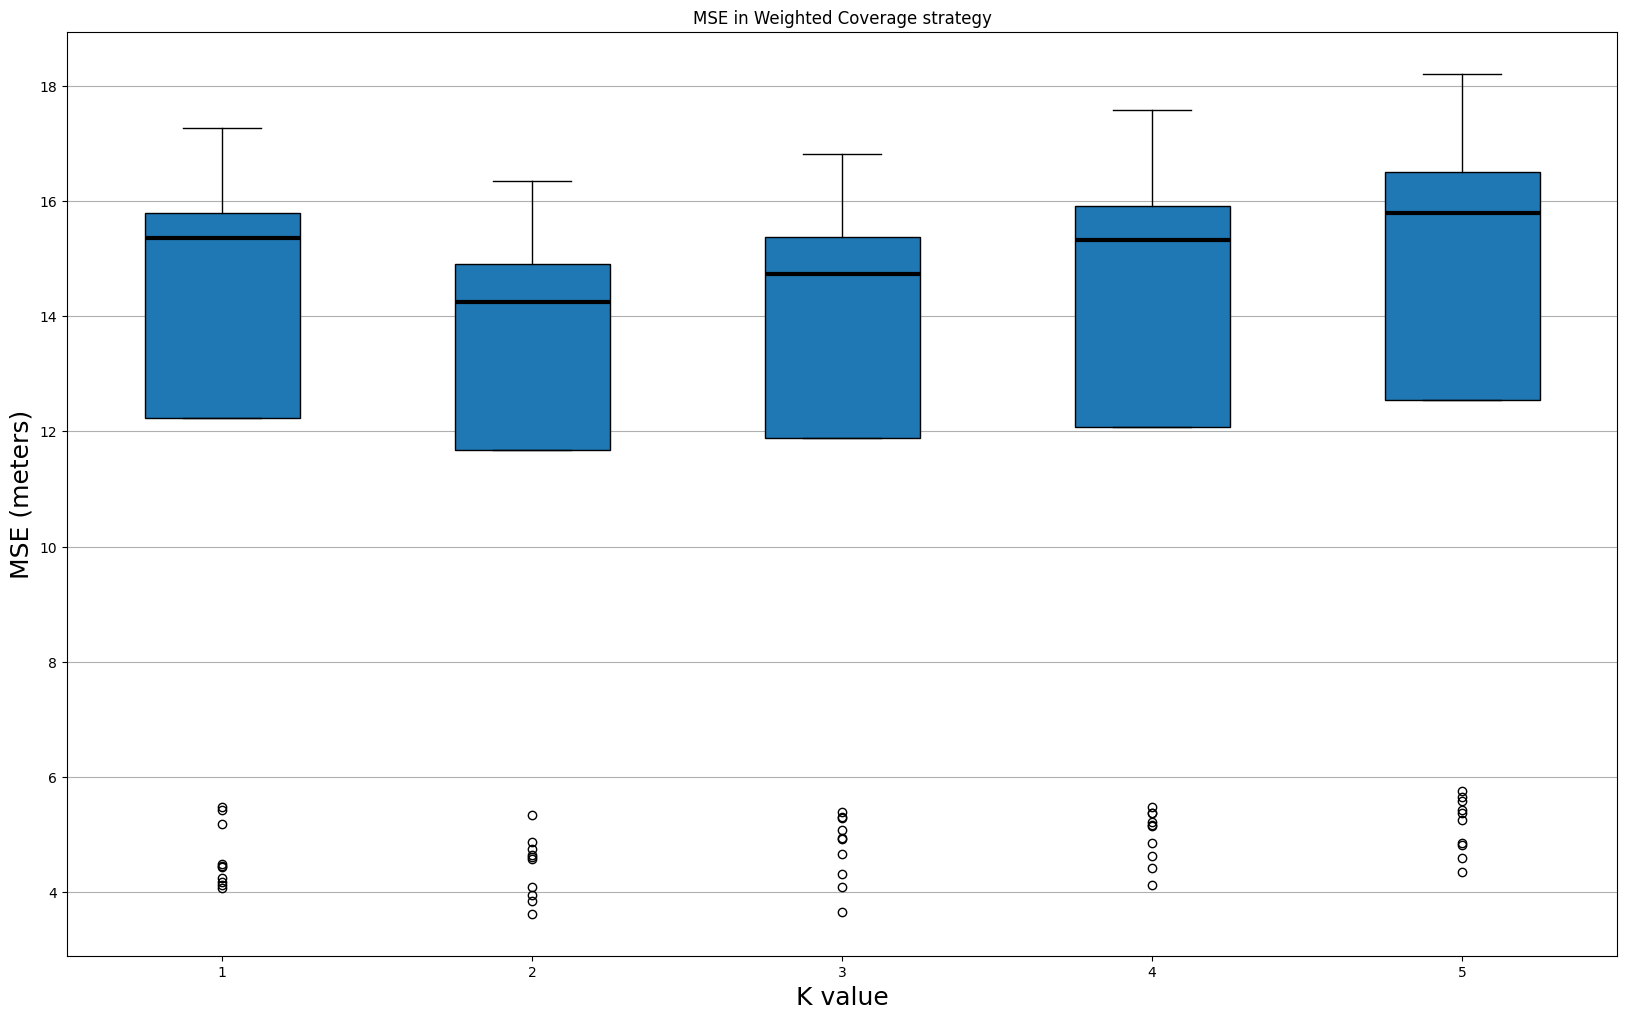

In [5]:
make_boxplot(errors_df)